In [1]:
import torch 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchmetrics
import os

from PIL import Image
from torch import nn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

from timeit import default_timer as timer
from tqdm import tqdm

In [2]:
import requests
from pathlib import Path 

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Function & Class Definitions ##

In [23]:
def trainLinear(model: torch.nn.Module,
                train_data: torch.Tensor,
                train_label: torch.Tensor,
                test_data: torch.Tensor,
                test_label: torch.Tensor,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                epochs: int):
    train_loss_total, test_loss_total, epoch_count = [], [], []
    for epoch in range(epochs):
        model.train()
        train_data, train_label = train_data.to(device), train_label.to(device)
        test_data, test_label = test_data.to(device), test_label.to(device)
        ### Forward pass
        train_logits = model(train_data)
        ### Calc loss
        train_loss = loss_fn(train_logits, train_label)
        ### Reset grad
        optimizer.zero_grad()
        ### Backprop
        train_loss.backward()
        ### Step weights
        optimizer.step()

        model.eval()
        with torch.inference_mode():
            test_logits = model(test_data)
            test_loss = loss_fn(test_logits, test_label)

            # Print per 10 epochs:
            if epoch % 100 == 0:
                epoch_count.append(epoch)
                train_loss_total.append(train_loss.cpu().detach().numpy())
                test_loss_total.append(test_loss.cpu().detach().numpy())
                print(f"Epoch: {epoch} | Train Loss: {train_loss:.2f} | Test Loss: {test_loss:.2f}")

In [5]:
class NonLinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10,10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.block1(x)

In [6]:
def trainNeuralNet(
    model: torch.nn.Module,
    train_data: torch.Tensor,
    train_labels: torch.Tensor,
    test_data: torch.Tensor,
    test_labels: torch.Tensor,
    loss_fn: torch.nn.Module, 
    optimizer: torch.optim.Optimizer,
    epochs: int
):
    for epoch in range(epochs):
        model.train()
        train_data, train_labels = train_data.to(device), train_labels.to(device)
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        
        train_logits = model(train_data).squeeze()
        train_loss = loss_fn(train_logits, train_labels)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        train_preds = torch.round(torch.sigmoid(train_logits))
        train_acc = (torch.eq(train_preds, train_labels).sum().item() / len(train_labels) * 100)

        model.eval()
        with torch.inference_mode():
            test_logits = model(test_data).squeeze()
            test_loss = loss_fn(test_logits, test_labels)
            test_preds = torch.round(torch.sigmoid(test_logits))
            test_acc = (torch.eq(test_preds, test_labels).sum().item() / len(test_labels) * 100)

        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | " 
            f"Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")

In [7]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(1, 10), 
            nn.Linear(10, 1),
        )
                                    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)

In [8]:
class CNNModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.block_2(self.block_1(x)))

In [9]:
def show_predictions(image, predictions):
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))  # Assuming the image is a PyTorch tensor

    for i, box in enumerate(predictions[0]['boxes']):
        label = predictions[0]['labels'][i]
        score = predictions[0]['scores'][i]
        if score > 0.5:  # Set a threshold for scores
            rect = patches.Rectangle(
                (box[0], box[1]), box[2] - box[0], box[3] - box[1],
                linewidth=1, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            plt.text(box[0], box[1], f'{label}: {score:.2f}', color='white',
                     fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

In [10]:
class LinearModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Linear(2, 10),
            nn.Linear(10,10),
            nn.Linear(10, 1)
        )
        
    def forward(self, x):
        return self.block1(x)

In [11]:
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_func: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device = device):

    train_loss, train_acc = 0,0
    model.to(device)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        # Send to Device
        X, y = X.to(device), y.to(device)
        # Forward Pass
        train_pred = model(X)
        # Caclulate Loss
        loss = loss_func(train_pred, y)
        train_loss += loss 
        train_acc += accuracy_fn(y, train_pred.argmax(dim=1))
        # Zero Grad
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Step Weights
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.5f}")

def test_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_func: torch.nn.Module,
             accuracy_fn,
             device: torch.device = device):

    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss = loss_func(test_pred, y)
            
            
            test_loss += loss
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.5f}")

In [51]:
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss += loss_fn(test_pred, y)
            acc += accuracy_fn(y, test_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__, # Only works when model is created by a class
        "model_loss": loss.item(),
        "model_acc": acc.item()
    }

In [13]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Model requires 4D Tensor
            sample = torch.unsqueeze(sample, dim=0).to(device)
            # Forward Pass into Model (Creates Logits)
            pred_logit = model(sample)
            # Get Prediction Probability / Our batch has 1 sample so we can perform on dim=0 
            # because squeezing means that from [batchsize, features] it turns into [features] 
            # thats why we can do dim=0
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            # Transfer Prediction Probabilty from GPU to CPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into tensor
    return torch.stack(pred_probs)

In [14]:
def plot_predictions(train_data,
                     train_labels,
                     test_data,
                     test_labels,
                     predictions = None
                    ):

    # This plots the training and testing data. In addition it also compares predictions.

    plt.figure(figsize=(10,7))
    
    # Plots training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
    
    # Plots testing data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")
    
    
    if predictions is not None:
        # Plots the predictions in red - if there are predictions made on the test data
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    
    plt.legend(prop={"size": 14});

## Linear Regression ##

In [15]:
torch.manual_seed(10)

weight = 0.7
bias = 0.3

# Creating Fake Data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [16]:
train_split = int(0.8 * len(X))  # 80% of data used for training set, 20% used for testing set.
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

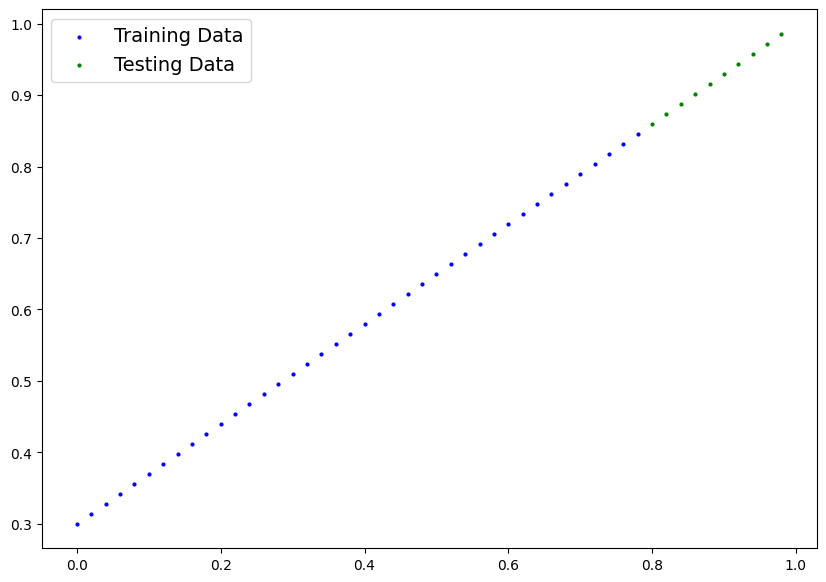

In [17]:
plot_predictions(X_train, y_train, X_test, y_test)

In [18]:
linear_model = LinearRegressionModel().to(device)
linear_model.to(device)

LinearRegressionModel(
  (block): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [19]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.01)

In [20]:
linear_model.eval()
with torch.inference_mode():
    untrained_preds = linear_model(X_test.to(device))
untrained_preds

tensor([[-0.4476],
        [-0.4516],
        [-0.4556],
        [-0.4595],
        [-0.4635],
        [-0.4675],
        [-0.4715],
        [-0.4755],
        [-0.4795],
        [-0.4835]], device='cuda:0')

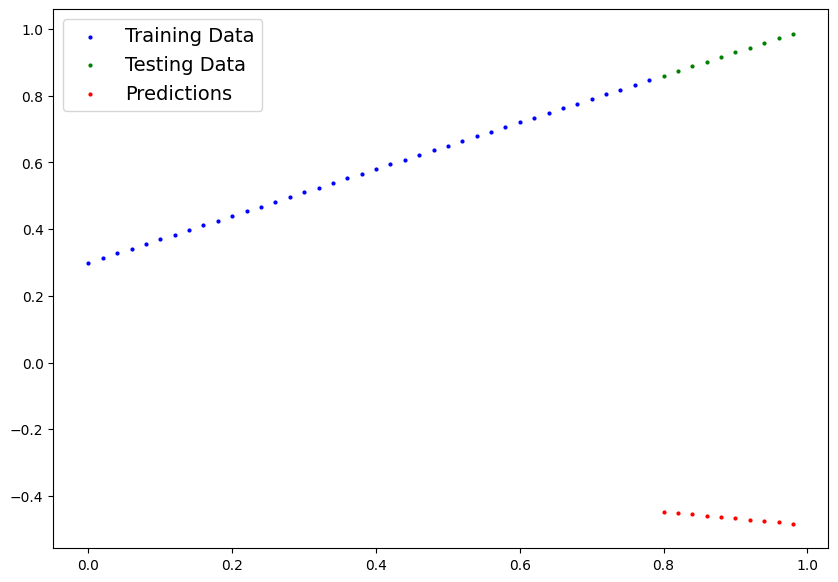

In [21]:
plot_predictions(X_train, y_train, X_test, y_test, predictions=untrained_preds.cpu())    

In [24]:
trainLinear(linear_model, X_train, y_train, X_test, y_test, loss_fn, optimizer, 500)

Epoch: 0 | Train Loss: 0.91 | Test Loss: 1.33
Epoch: 100 | Train Loss: 0.10 | Test Loss: 0.25
Epoch: 200 | Train Loss: 0.01 | Test Loss: 0.02
Epoch: 300 | Train Loss: 0.00 | Test Loss: 0.03
Epoch: 400 | Train Loss: 0.01 | Test Loss: 0.03


In [26]:
linear_model.eval()
with torch.inference_mode():
    trained_preds = linear_model(X_test.to(device))
trained_preds

tensor([[0.8607],
        [0.8744],
        [0.8880],
        [0.9017],
        [0.9153],
        [0.9290],
        [0.9427],
        [0.9563],
        [0.9700],
        [0.9836]], device='cuda:0')

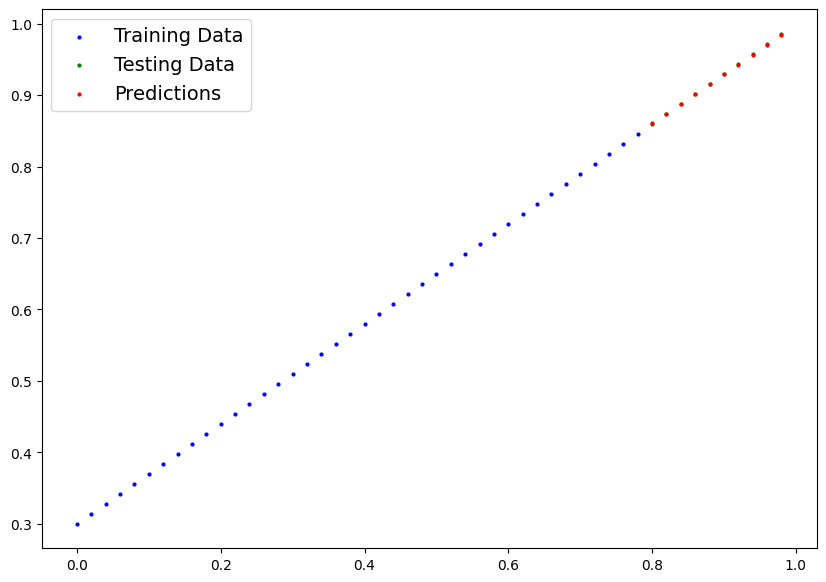

In [28]:
plot_predictions(X_train, y_train, X_test, y_test, predictions=trained_preds.cpu())    

## Introducing Non-Linearity ##

In [29]:
nonlinear_model = NonLinearModel().to(device)
linear_modelV2 = LinearModelV2().to(device)

nonlinear_model, linear_modelV2

(NonLinearModel(
   (block1): Sequential(
     (0): Linear(in_features=2, out_features=10, bias=True)
     (1): ReLU()
     (2): Linear(in_features=10, out_features=10, bias=True)
     (3): ReLU()
     (4): Linear(in_features=10, out_features=1, bias=True)
   )
 ),
 LinearModelV2(
   (block1): Sequential(
     (0): Linear(in_features=2, out_features=10, bias=True)
     (1): Linear(in_features=10, out_features=10, bias=True)
     (2): Linear(in_features=10, out_features=1, bias=True)
   )
 ))

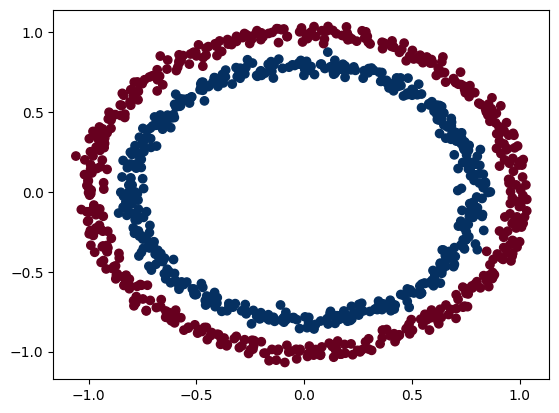

In [30]:
X,y = make_circles(n_samples=1000, noise=0.03, random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdBu);

In [31]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [32]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_modelV2.parameters(), lr=0.1)

In [33]:
### Training Linear Model 

trainNeuralNet(linear_modelV2, X_train, y_train, X_test, y_test, loss_fn, optimizer, 1500)

Epoch: 0 | Loss: 0.69483, Accuracy: 50.00% | Test Loss: 0.69671, Test Acc: 50.00
Epoch: 100 | Loss: 0.69299, Accuracy: 50.75% | Test Loss: 0.69478, Test Acc: 47.50
Epoch: 200 | Loss: 0.69298, Accuracy: 51.12% | Test Loss: 0.69471, Test Acc: 46.00
Epoch: 300 | Loss: 0.69298, Accuracy: 51.50% | Test Loss: 0.69469, Test Acc: 44.50
Epoch: 400 | Loss: 0.69298, Accuracy: 51.25% | Test Loss: 0.69468, Test Acc: 45.50
Epoch: 500 | Loss: 0.69298, Accuracy: 51.12% | Test Loss: 0.69468, Test Acc: 46.00
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Acc: 46.00
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Acc: 46.00
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Acc: 46.00
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Acc: 46.00
Epoch: 1000 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Acc: 46.00
Epoch: 1100 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Acc: 46.00
Epoc

In [34]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

In [35]:
trainNeuralNet(nonlinear_model, X_train, y_train, X_test, y_test, loss_fn, optimizer, 1500)

Epoch: 0 | Loss: 0.69581, Accuracy: 50.00% | Test Loss: 0.69438, Test Acc: 50.00
Epoch: 100 | Loss: 0.69237, Accuracy: 49.88% | Test Loss: 0.69177, Test Acc: 51.00
Epoch: 200 | Loss: 0.69155, Accuracy: 52.00% | Test Loss: 0.69121, Test Acc: 51.00
Epoch: 300 | Loss: 0.69053, Accuracy: 57.88% | Test Loss: 0.69041, Test Acc: 55.50
Epoch: 400 | Loss: 0.68900, Accuracy: 60.25% | Test Loss: 0.68909, Test Acc: 57.50
Epoch: 500 | Loss: 0.68652, Accuracy: 60.00% | Test Loss: 0.68695, Test Acc: 55.50
Epoch: 600 | Loss: 0.68233, Accuracy: 59.13% | Test Loss: 0.68333, Test Acc: 57.50
Epoch: 700 | Loss: 0.67549, Accuracy: 58.50% | Test Loss: 0.67718, Test Acc: 60.00
Epoch: 800 | Loss: 0.66448, Accuracy: 61.00% | Test Loss: 0.66692, Test Acc: 64.50
Epoch: 900 | Loss: 0.64539, Accuracy: 63.25% | Test Loss: 0.64822, Test Acc: 66.50
Epoch: 1000 | Loss: 0.60483, Accuracy: 81.25% | Test Loss: 0.61143, Test Acc: 83.00
Epoch: 1100 | Loss: 0.51898, Accuracy: 98.00% | Test Loss: 0.53484, Test Acc: 96.00
Epoc

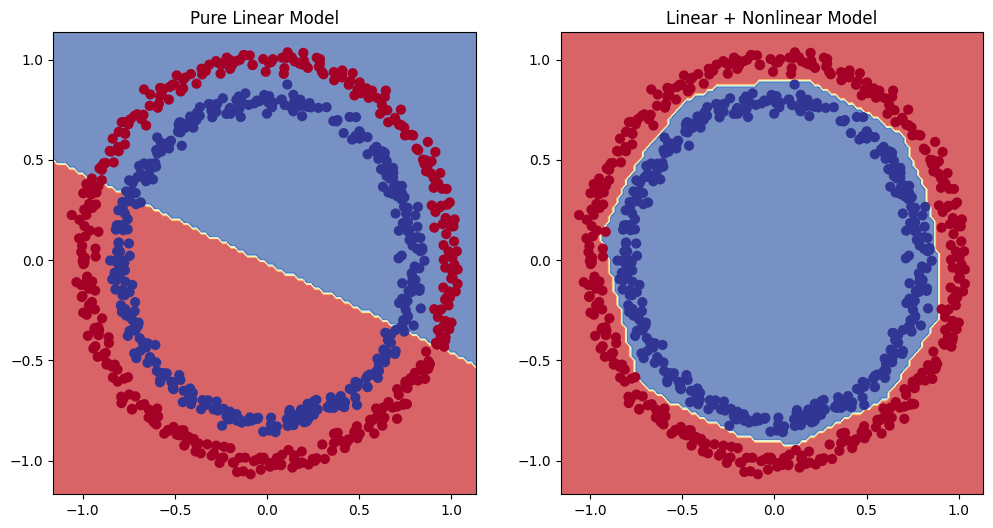

In [36]:
# Plotting decision boundaries for training & test sets
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Pure Linear Model")
plot_decision_boundary(linear_modelV2, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Linear + Nonlinear Model")
plot_decision_boundary(nonlinear_model, X_train, y_train)

## Convolutional ##

In [37]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True, 
    transform=ToTensor(),
    target_transform=None 
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [38]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [39]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x19cff759760>,
 <torch.utils.data.dataloader.DataLoader at 0x19cff7f8410>)

In [43]:
cnn_model = CNNModel(1, 10, len(class_names))
cnn_model.to(device)

CNNModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [47]:
accuracy_fn = torchmetrics.Accuracy(task='multiclass', num_classes=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), 0.1)

In [48]:
torch.manual_seed(42)

train_time_start = timer()

epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")
    train_step(
        dataloader=train_dataloader,
        model=cnn_model,
        loss_func=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

    test_step(
        dataloader=test_dataloader,
        model=cnn_model,
        loss_func=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end = timer()
total_train_time = train_time_end - train_time_start
print(f"Total Train Time: {total_train_time} Seconds")

  0%|                                                                                                                                                                                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch: 0
--------
Train Loss: 0.67362 | Train Accuracy: 0.75502


 20%|████████████████████████████████████████████████▊                                                                                                                                                                                                   | 1/5 [00:25<01:41, 25.26s/it]

Test Loss: 0.38890 | Test Accuracy: 0.86182
Epoch: 1
--------
Train Loss: 0.35943 | Train Accuracy: 0.86965


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 2/5 [00:49<01:14, 24.91s/it]

Test Loss: 0.38694 | Test Accuracy: 0.86312
Epoch: 2
--------
Train Loss: 0.32288 | Train Accuracy: 0.88292


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 3/5 [01:13<00:48, 24.12s/it]

Test Loss: 0.36184 | Test Accuracy: 0.86791
Epoch: 3
--------
Train Loss: 0.30203 | Train Accuracy: 0.89002


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 4/5 [01:35<00:23, 23.50s/it]

Test Loss: 0.31082 | Test Accuracy: 0.88748
Epoch: 4
--------
Train Loss: 0.28670 | Train Accuracy: 0.89590


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:57<00:00, 23.57s/it]

Test Loss: 0.29809 | Test Accuracy: 0.88808
Total Train Time: 117.86500290001277 Seconds


In [52]:
cnn_model_results = eval_model(
    cnn_model,
    test_dataloader,
    loss_fn,
    accuracy_fn
)

cnn_model_results

{'model_name': 'CNNModel',
 'model_loss': 0.29814043641090393,
 'model_acc': 0.888079047203064}

In [53]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape & label
print(f"Test Sample Image Shape: {test_samples[0].shape}\nTest Sample Image Label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test Sample Image Shape: torch.Size([1, 28, 28])
Test Sample Image Label: 5 (Sandal)


In [54]:
pred_probs = make_predictions(cnn_model, test_samples)
pred_probs[:2]

pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

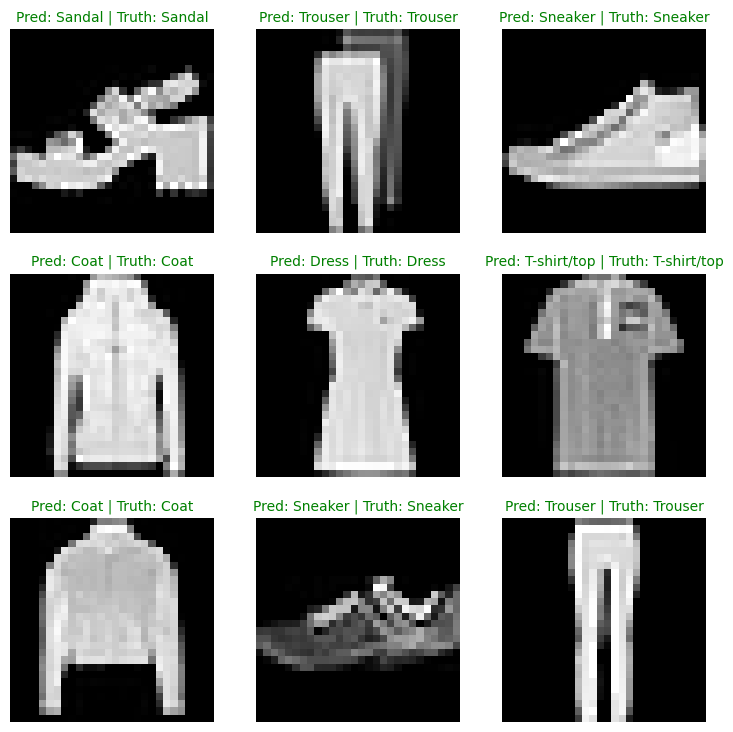

In [55]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)
    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")
    # Finding the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[pred_classes[i]]
    # Get the truth label (in text form e.g "T-shirt")
    truth_label = class_names[test_labels[i]]
    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
    plt.axis(False);

# Regional Convolutional Neural Network # 

In [56]:
im = Image.open('./images/test0.jpg')
transform = ToTensor()
tensor = [transform(im)]
tensor

[tensor([[[0.4157, 0.4157, 0.4157,  ..., 0.9490, 0.9490, 0.9451],
          [0.4118, 0.4118, 0.4118,  ..., 0.9412, 0.9412, 0.9412],
          [0.3961, 0.3961, 0.4000,  ..., 0.9373, 0.9333, 0.9333],
          ...,
          [0.1686, 0.0902, 0.2157,  ..., 0.0824, 0.0784, 0.0627],
          [0.2118, 0.0980, 0.2353,  ..., 0.0863, 0.0824, 0.0745],
          [0.1804, 0.1294, 0.4157,  ..., 0.0902, 0.0902, 0.0824]],
 
         [[0.3686, 0.3686, 0.3686,  ..., 0.9294, 0.9294, 0.9255],
          [0.3647, 0.3647, 0.3647,  ..., 0.9216, 0.9216, 0.9216],
          [0.3608, 0.3608, 0.3647,  ..., 0.9176, 0.9137, 0.9137],
          ...,
          [0.2000, 0.1294, 0.2667,  ..., 0.0941, 0.0902, 0.0745],
          [0.2314, 0.1294, 0.2784,  ..., 0.0980, 0.0941, 0.0784],
          [0.2039, 0.1647, 0.4627,  ..., 0.1020, 0.1020, 0.0863]],
 
         [[0.3059, 0.3059, 0.3059,  ..., 0.9059, 0.9059, 0.9020],
          [0.3020, 0.3020, 0.3020,  ..., 0.8980, 0.8980, 0.8980],
          [0.2941, 0.2941, 0.2980,  ...,

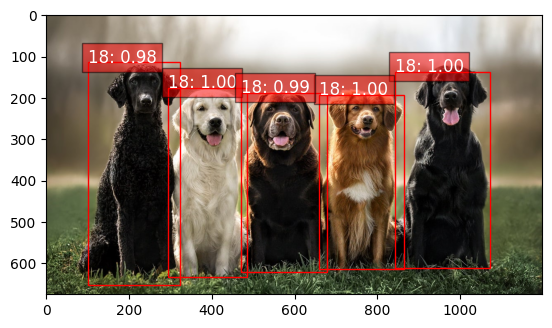

In [57]:
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model1 = fasterrcnn_resnet50_fpn(weights=weights)
with torch.inference_mode():
    model1.eval()
    predictions = model1(tensor)

show_predictions(tensor[0], predictions)

[Link To Class List For COCO Dataset](https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/)